<a href="https://colab.research.google.com/github/Dominic-byte/Team-13-Regression-Predict/blob/master/Sendy_regressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Team 13 Sendy Logistics Challenge

## Contents (finish sections 4, 5, 6, 7, 8, 9)

1. Introduction
2. Imports
3. Definitions
4. Data cleaning and preprocessing
5. Exploratoory data analysis
6. Feature engineering and selection
7. Model building
8. Results interpretation
9. Conclusion

## 1. Introduction

**Problem Landscape**

*About Sendy:* Sendy is a platform established to enable businesses to transport goods efficently across East Africa. Sendy focuses on on building practical solutions for Africa's transportation needs, from developing apps and web solutions, to providing dedicated support for goods on the move.

*Problem* Sendy would like to be able to predict the estimated time of delivery of orders from the point of driver pickup to the point of arrival at final destination.

*Value* This will help Sendy improve customer experience by enhancing customer communication and improving service reliability. In addition, the solution will enable the realisation of cost savings through improved resource management.

*Problem Statement*: **Build** a model to predict the estimated time of delivery of orders from the **`point of driver pickup`** to the **`point of arrival at final destination`**.

## 2. Imports

Packages

In [0]:
%%capture
# Standard Imports
import numpy as np
import pandas as pd

# Visualisations
import matplotlib.pyplot as plt
import seaborn as sns

# Feature engineering
import geopy.distance

# Modelling
from sklearn.preprocessing import StandardScaler

# Notebook Settings
%matplotlib inline
pd.options.display.max_columns = 60
sns.set_style("whitegrid")

Data

In [0]:
# URL to training and testing data
trurl = 'https://raw.githubusercontent.com/Dominic-byte/Team-13-Regression-Predict/master/Train.csv'
turl = 'https://raw.githubusercontent.com/Dominic-byte/Team-13-Regression-Predict/master/Test.csv'
rurl = 'https://raw.githubusercontent.com/Dominic-byte/Team-13-Regression-Predict/master/Riders.csv'
vurl = 'https://raw.githubusercontent.com/Dominic-byte/Team-13-Regression-Predict/master/VariableDefinitions.csv'

# Loading datasets
train_df = pd.read_csv(trurl, index_col=0)
test_df = pd.read_csv(turl, index_col=0)
riders_df = pd.read_csv(rurl)
variables = pd.read_csv(vurl, index_col=0)

## 3. Definitions

In [29]:
pd.options.display.max_colwidth = 0
variables

,Unique number identifying the order
Order No,
User Id,Unique number identifying the customer on a platform
Vehicle Type,"For this competition limited to bikes, however in practice Sendy service extends to trucks and vans"
Platform Type,"Platform used to place the order, there are 4 types"
Personal or Business,Customer type
Placement - Day of Month,Placement - Day of Month i.e 1-31
Placement - Weekday (Mo = 1),Placement - Weekday (Monday = 1)
Placement - Time,Placement - Time - Time of day the order was placed
Confirmation - Day of Month,Confirmation - Day of Month i.e 1-31
Confirmation - Weekday (Mo = 1),Confirmation - Weekday (Monday = 1)


In [0]:
pd.options.display.max_colwidth = 50

In [0]:
def col_rename(df):
  """Function that renames columns and drops columns that 
  were not used in the test set
  Parameters
  ----------
  df: DataFrame
          input df to rename columns for
  Returns
  -------
  new_df: DataFrame
          output df with renamed and dropped columns
          as well as a printout of dropped columns
  """
  static_dict = {"Order No":"Order No","User Id":"User Id","Vehicle Type":"Vehicle Type","Platform Type":"Platform",
        "Personal or Business":"Pers Business","Placement - Day of Month":"Place DoM",
        "Placement - Weekday (Mo = 1)":"Place Weekday","Placement - Time":"Place Time",
        "Confirmation - Day of Month":"Confirm DoM","Confirmation - Weekday (Mo = 1)":"Confirm Weekday",
        "Confirmation - Time":"Confirm Time","Arrival at Pickup - Day of Month":"Arr Pickup DoM",
        "Arrival at Pickup - Weekday (Mo = 1)":"Arr Pickup Weekday","Arrival at Pickup - Time":"Arr Pickup Time",
        "Pickup - Day of Month":"Pickup DoM","Pickup - Weekday (Mo = 1)":"Pickup Weekday","Pickup - Time":"Pickup Time",
        "Distance (KM)":"Distance KM","Temperature":"Temperature","Precipitation in millimeters":"Precipitation mm",
        "Pickup Lat":"Pickup Lat","Pickup Long":"Pickup Long","Destination Lat":"Destination Lat","Time from Pickup to Arrival":"Time from Pickup to Arrival",
        "Destination Long":"Destination Long","Rider Id":"Rider Id"}
  new_df = df.copy()
  new_cols = {}
  droplist = []
  for col in new_df.columns:
    if col in static_dict.keys():
      new_cols[col] = static_dict[col].replace(" ","_")
    else:
      droplist.append(col)
  new_df.rename(columns = new_cols, inplace=True)
  for col in droplist:
    if col in new_df.index:
      return new_df.drop(columns=droplist, inplace=True)
  return new_df

In [0]:
atrain_df  = col_rename(train_df)
atest_df =  col_rename(test_df)
ariders_df = col_rename(riders_df)

In [33]:
for col in atrain_df.columns:
    if col not in atest_df.columns and col != 'Time_from_Pickup_to_Arrival':
        print(col)
        atrain_df.drop(columns=col, inplace = True)

Arrival at Destination - Day of Month
Arrival at Destination - Weekday (Mo = 1)
Arrival at Destination - Time


In [34]:
# Storing variable names and test index
train_columns = atrain_df.columns
test_columns = atest_df.columns
riders_columns = ariders_df.columns
test_index = atest_df.index
target = train_columns[-1]

# Inspect data
print(train_df.shape, test_df.shape, riders_df.shape)
train_df.head(3)
print(target)

(21201, 28) (7068, 24) (960, 5)
Time_from_Pickup_to_Arrival


## 4. Data cleaning and preprocessing (BBP)

In [35]:
pd.merge(atrain_df, ariders_df, how='left', on='Rider_Id').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21201 entries, 0 to 21200
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   User_Id                      21201 non-null  object 
 1   Vehicle_Type                 21201 non-null  object 
 2   Platform                     21201 non-null  int64  
 3   Pers_Business                21201 non-null  object 
 4   Place_DoM                    21201 non-null  int64  
 5   Place_Weekday                21201 non-null  int64  
 6   Place_Time                   21201 non-null  object 
 7   Confirm_DoM                  21201 non-null  int64  
 8   Confirm_Weekday              21201 non-null  int64  
 9   Confirm_Time                 21201 non-null  object 
 10  Arr_Pickup_DoM               21201 non-null  int64  
 11  Arr_Pickup_Weekday           21201 non-null  int64  
 12  Arr_Pickup_Time              21201 non-null  object 
 13  Pickup_DoM      

### a. Data types

** *italicized text*Numerical**
- Ratio
  - *Number of Orders*
  - *Age*
  - *Number of Ratings*
  - *Time from pickup to arrival* - Target
  - *Geospatial Distance*`
- Interval
  - *Time (Placement, Confimation, Arrival, etc)* 
  - *Distance (KM)*
  - *Temperature*
  - *Precipitation*
  - *Co-ordinates*

**Categorical**
- Nominal
  - *User Id*
    - This is categorical as it only varies in the user that has\
      placed the order.
    - It may be possible to determine the frequency of orders\
      placed by customers and determine their loyalty. This may\
      reflect a drivers motivation to provide higher quality\
      service to that user.
  - *Vehicle Type*
    - The type of vehicle used would ordinarily have an impact on\
      delivery time as a motorcycle would be faster than a truck.
    - Since there is only one vehicle type to consider (bike)\
      there is no value to be gained from this data
  - *Platform Type*
    - The source of order placement is qualitative and may give\
      information about the level of service delivery for the\
      various platforms. More frequently used platforms may be\
      serviced better by drivers as they may provide a steady\
      stream of customers.
    - The platform can only take on the values from 1 to 4 and\
      should be stored as an `int16`
  - *Personal or Business*
    - Business orders are likely to be frequent and and located\
      near central business district, whereas personal orders\
      may require further travel to suburban areas. This could\
      have an effect on the travel time.
  - *Day of month (Placement, Confimation, Arrival, etc)*
    - The day of month can only vary in its quality. There may\
      more or less orders placed on a given day of the month.\
    - Since the values of day of month can take on values between\
      1 and 31 it would be most effecient to store it as an `int16`\
      instead of `int64` which is for larger numbers.
    - It may be that more orders are placed on certain days that\
      would result in longer delivery times.    
  - *Weekday*
    - Businesses typically operate on weekdays. It would logically\
      follow that weekdays are busier than weekends resulting in\
      longer delivery times due  to traffic or the volume of\
      orders.
    - Since the weekday is represented by 1 to 7, it should be\
      stored as an `int16`
    - *Rider Id*

- Ordinal
  - *Average rating*
    - Drivers are usually rated on a scale from one to 5. As a driver\
      recieves more ratings, the will begin to settle around their\
      true score. This score could reflect the driver's performance\
      with respect to timeliness.

**Continuous data**

The evaluation of continuous data is that they are values that can assume and value over a specific range. We will now look at all the features that represent continuous characteristics and evaluate thenon our explanatory data analysis

- Time(Placement, Arrival, Pickup etc)
 - Times can occur at and given instance in a 24hr range. Due to the flexible nature of time given in hrs, minutes and seconds it is safe to say this follows a continuous scale
 -Times can occur at any moment and the column value shows the randomness of that time.
Time is saved as objects(string values). The idea is to save them as date time objects and extract meaningful insights on the different times
 - We will gather insights from extracting hour, minutes and seconds data from the datetime objects

- Latitutude and Longitude data(Pickup Long and Lat, Destination Long and lat)

 - Lat and Long information depicts every location to be represented by a scale of numbers on Earth. Now these numbers may exist on the span of the entire globe since the earth is very big. 
 - Since  continuous in nature. We would like to gather insights by using geopy library to get exact distance

- Temperature
  - Temperature is a continuous variable due to its ability to take any value from a set of real numbers between -273 degrees Celsius to positive infinity.
  - It is currently saved as float64, we can take it down to int16 because the values are not large enoough to take on that value
  - Contains missing values, we would like to see the best strategy to fill the missing values with

- Precipitation in millimeters
 - Precipitation is a contiuous scale due to it being able to assume any value from zero to infinity. 
 - It is also saved as an float64 and we can take down to float16 due to the numbers not being too large
 - Large Quantity of missing values, we will investing gather what is the best strategy to deal with the missing values


### b. Cleaning functions

In [0]:
def data_preprocessing(df):
  """Function that preprocesses data used for predictions and testing
  Parameters
  ----------
  df: DataFrame
          DataFrame to preprocess.
  Returns
  -------
  df: DataFrame
          Preprocessed DataFrame

  """
  cdf = df.copy()
  old = cdf.memory_usage().sum()
  # Create lists of columns to change
  integers = [col for col in cdf.columns if cdf[col].dtypes == 'int64']
  floats = [col for col in cdf.columns if cdf[col].dtypes == 'float64']
  time_cols = [col for col in cdf.columns if col.endswith("Time")]

  # Reduce size of data storage types
  cdf[integers] = cdf[integers].astype('int16')
  cdf[floats] = cdf[floats].astype('float16')
  for col in time_cols:
    cdf[col] = pd.to_datetime(cdf[col]).dt.time
  
  # Correcting specific columns
  if 'Distance (KM)' in cdf.columns:
    cdf['Distance (KM)'] = cdf['Distance (KM)'].astype('float16') 

  new = cdf.memory_usage().sum()
  print("Bytes\t","\nOld:\t", str(old), "\nNew:\t", "("+str(new)+")", "\nSaved:\t", str(old - new))
  return cdf

In [0]:
%%capture [--no-display]
# Store transformations in EDA DataFrame
eda_df, eda_test, eda_riders = data_preprocessing(atrain_df), data_preprocessing(atest_df), data_preprocessing(ariders_df)

## 5. Data Exploration and preparation

### a. Exploratory data analysis


#### 1. Target - Time from Pickup to Arrival

In [38]:
# Confirming the caluclation of the Target
Target = pd.to_datetime(train_df['Arrival at Destination - Time']) - pd.to_datetime(train_df['Pickup - Time'])
list(Target.dt.seconds[:]) == list(atrain_df[target][:])

True

In [39]:
eda_df[target].describe()

count    21201.000000
mean      1556.920947
std        987.270788
min          1.000000
25%        882.000000
50%       1369.000000
75%       2040.000000
max       7883.000000
Name: Time_from_Pickup_to_Arrival, dtype: float64

**Analysis:** **Measures of central tendency**

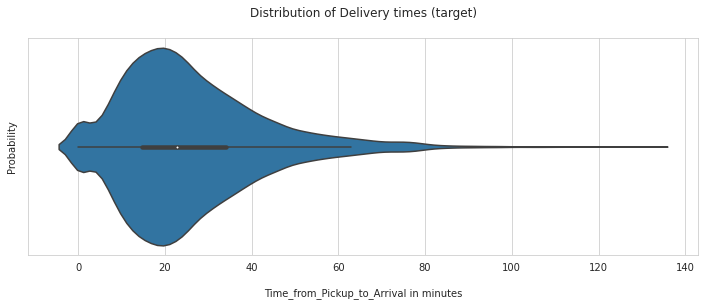

In [40]:
# Histogram
fig = plt.figure(figsize=(12,4))
sns.violinplot(eda_df[target]/60)
plt.title('Distribution of Delivery times (target)\n')
plt.xlabel('\n'+target+' in minutes')
plt.ylabel("Probability")
plt.show()

#### 2. Univariate analysis (D)

2.1 Numerical

In [41]:
#Analysing the features based on one variable type
col_numerical = [col for col in eda_df.columns if eda_df[col].dtypes != 'object' and col !=target]
eda_df[col_numerical].describe()

,Platform,Place_DoM,Place_Weekday,Confirm_DoM,Confirm_Weekday,Arr_Pickup_DoM,Arr_Pickup_Weekday,Pickup_DoM,Pickup_Weekday,Distance_KM,Temperature,Precipitation_mm,Pickup_Lat,Pickup_Long,Destination_Lat,Destination_Long
count,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,1.683500e+04,552.000000,21201.000000,2.120100e+04,21201.000000,2.120100e+04
mean,2.752182,15.653696,3.240083,15.653837,3.240225,15.653837,3.240225,15.653837,3.240225,9.506533,inf,7.906250,-1.281250,inf,-1.282227,inf
std,0.625178,8.798916,1.567295,8.798886,1.567228,8.798886,1.567228,8.798886,1.567228,5.668963,3.617188e+00,17.093750,0.030548,3.918457e-02,0.034851,4.562378e-02
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.120312e+01,0.099976,-1.438477,3.665625e+01,-1.430664,3.659375e+01
25%,3.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,5.000000,2.059375e+01,1.074219,-1.300781,3.678125e+01,-1.300781,3.678125e+01
50%,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,8.000000,2.350000e+01,2.900391,-1.279297,3.681250e+01,-1.284180,3.681250e+01
75%,3.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,13.000000,2.600000e+01,4.898438,-1.256836,3.684375e+01,-1.260742,3.684375e+01
max,4.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,49.000000,3.209375e+01,99.125000,-1.147461,3.700000e+01,-1.030273,3.703125e+01


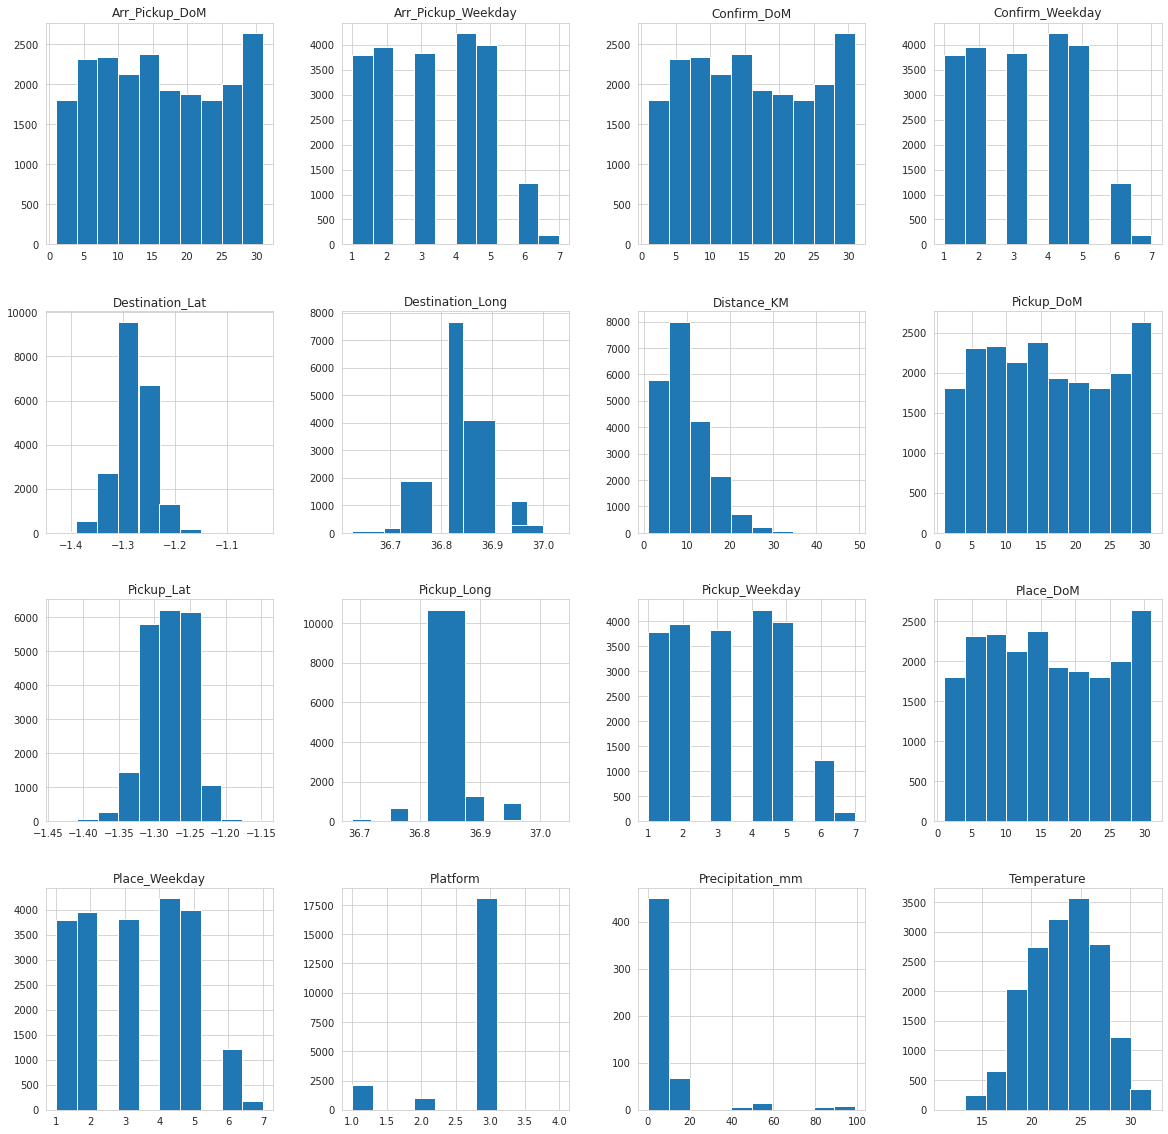

In [42]:
#Plot histogram of numerical values
def histogram_plot(df,cols,bins = 10):

  """Function creates histogram of all numerical columns
  Parameters
  ----------
  df: DataFrame
          DataFrame to preprocess.
  cols: list
          list of numerical columns or object columns
  bins: string
          number of bins you want histogram to create
  Returns
  -------
  {Plot}: Returns plot of column histograms for analysis
          
  """
  df[cols].hist(bins = bins, figsize  = (20,20))
  return plt.show()
histogram_plot(eda_df,col_numerical,10)

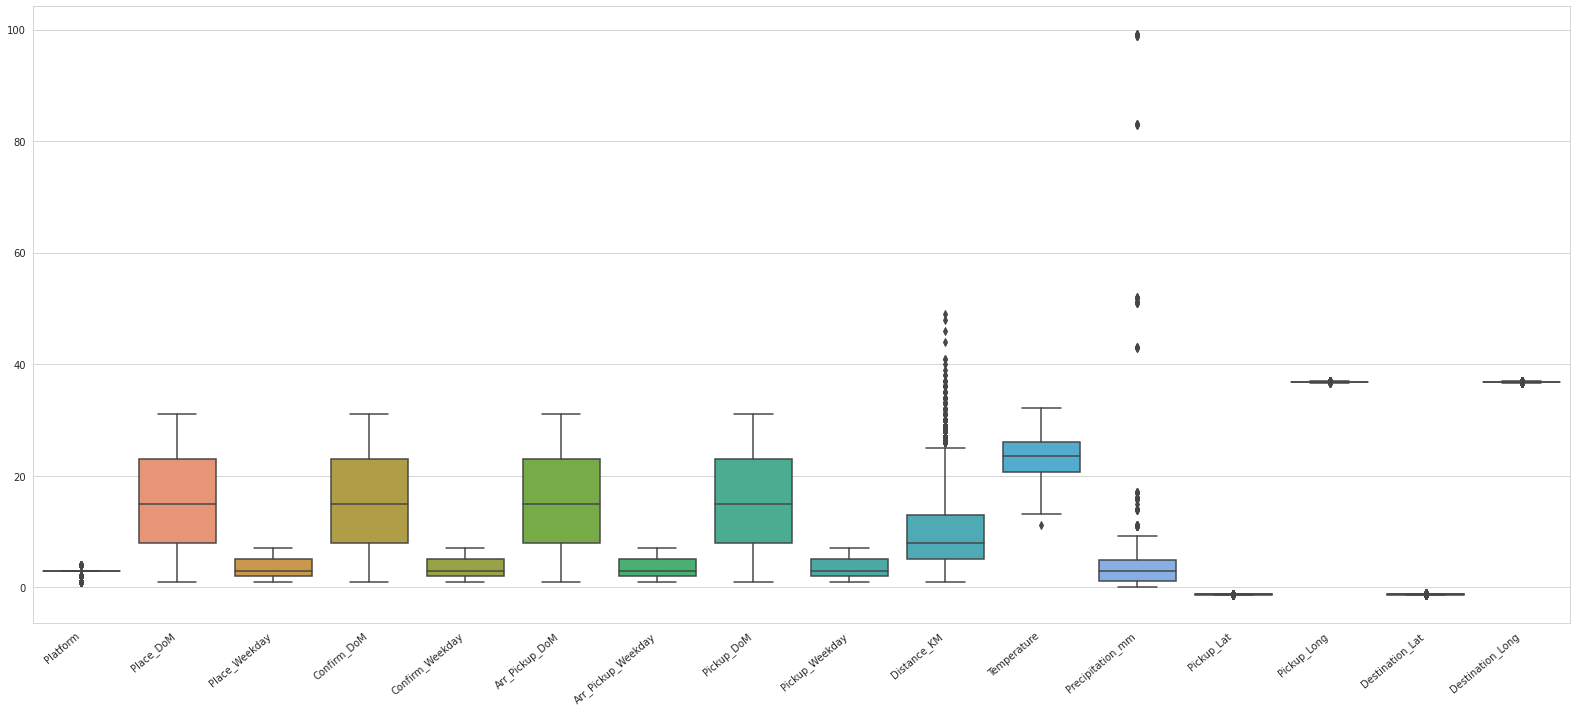

In [43]:
#Plot Boxplot of graphs
def box_plot(df,cols):
  """Function creates histogram of all numerical columns
  Parameters
  ----------
  df: DataFrame
          DataFrame to preprocess.
  cols: list
          list of numerical columns
  Returns
  -------
  {Plot}: Returns plot of boxplot for dataframe
          
  """
  plt.figure(figsize=(22,10))
  ax = sns.boxplot(data = df[cols])
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
  plt.tight_layout()
  return plt.show()
box_plot(eda_df,col_numerical)

**Analysis:** **Histogram**

From the individual numerical data plots, You can see that all the weekday varaibles follow uniform distribution except for Saturday and Sunday. Those appear to be very low compared to deliveries in the week.  

All data for days of the month follow a bimodal distribution and the peaks seem to vary between day 5-15 and day 25-30 which insinuates that the customers have capital to spend money on deliveries in these days of the month, but day 30 seems to have an exceedingly high peak compared to the rest of the days, this could be due to every client getting paid at the end of the month. 

Destination lat and long show normal distribution with most of the deliveries going to approximately (-1.28,36.85)

Pickup lat follows a normal distribution with a peak of (-1.27) and Pickup long shows a skewed left distribution which means most of the observations are happening around coordinate (36.9). Approximately between these two coordinates seem to be where most of the pickups happen.

The platform type distribution is left skewed showing that most of the deliveries by a substantial amount happen on platform 3. 

Temperature follows a normal distribution with the peak being 23.5. Distance and precipitation show a skewed right distribution with most of the kilometres ranging between 0-15km and most precipitation ranging from 0-5mm of rain.

**Analysis:** **Boxplot**

From looking at the box plot, all numerical values range differently from the plot above therefore might have to do some standardisation/normalisation for the models that depend on scaling for accuracy, the GPS range is very small since a changing the decimal coordinates slightly takes you to a new area. The distance and precipitation show outliers that may affect our results so we need to pay close attention to these two variables.



2.2 Objects

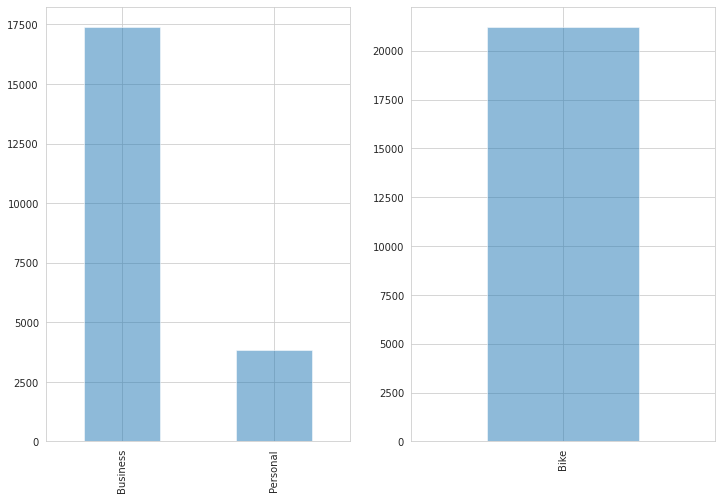

In [44]:
#Plotting two histograms to show insight of the Vehicle type and customer type
obj2_cols = [col for col in eda_df.columns if (col == 'Pers_Business')] + ['Vehicle_Type']
fig,axes = plt.subplots(1, len(obj2_cols), figsize=(12,8), squeeze=False)

for i, col in enumerate(obj2_cols):
    eda_df[obj2_cols[i]].value_counts().plot(kind='bar', x=col, ax=axes[0, i], alpha=0.5)

plt.show()

**Analysis**

From looking at the results, it shows that mainly businesses use the delivery platform and the vehicle type is only bike. Since the Vehicle type is only bike, it is safe to drop the vehicle type column as it is giving no insight to the dependent variable

In [0]:
%%capture
#Creating a hour dataframe to to get insight at the total number of deliveries volume per hour. 
#This will show in which hours most of the deliveries were made

import datetime as dt
time_cols = [col for col in eda_df.columns if col.endswith('Time')]
time_df = eda_df[time_cols]

for col in time_cols:
    time_df[col] = pd.to_datetime(time_df[col], format='%H:%M:%S').dt.strftime("%H:%M:%S")
#Create hour function
def hour(df,cols):
    for col in cols:
        df[col] = df[col].apply(lambda x: int(x[:2]))
    return df

hour_df = hour(time_df,time_cols)

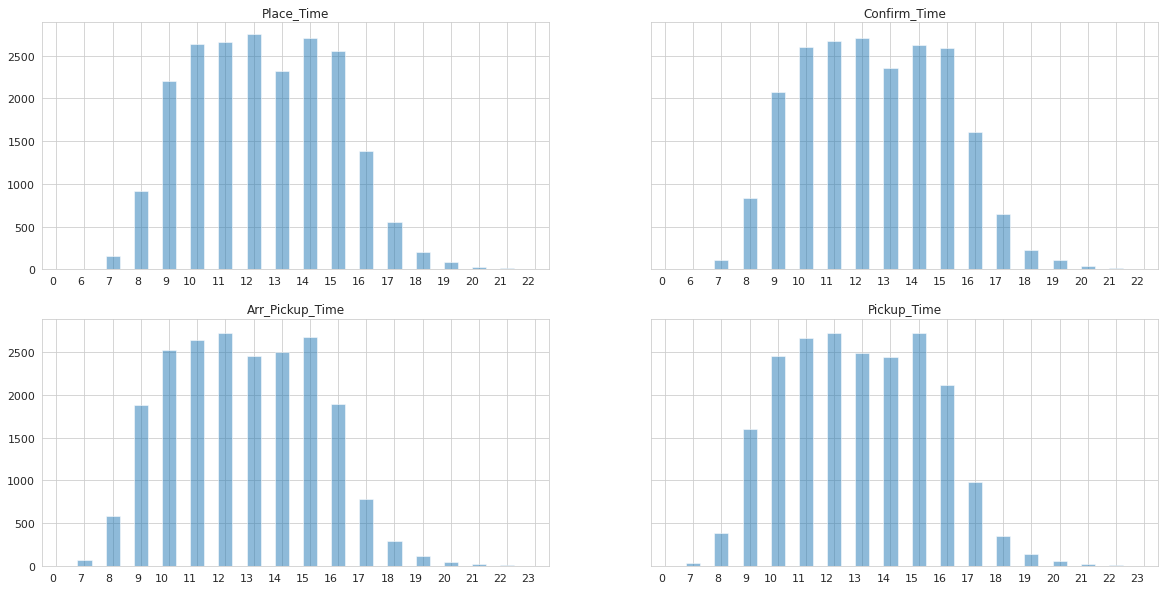

In [46]:
#Analysing the hours for further insight with bar graphs
col_names = hour_df.columns

fig,axes = plt.subplots(2,2, figsize=(20,10), squeeze=False,sharey=True)
hour_df[col_names[0]].value_counts().sort_index().plot(kind='bar',x=col_names[i], ax=axes[0, 0], alpha=0.5)
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=0, ha="right")
axes[0, 0].tick_params(labelsize=11)
axes[0, 0].set_title(col_names[0])

hour_df[col_names[1]].value_counts().sort_index().plot(kind='bar',x=col_names[i], ax=axes[0, 1], alpha=0.5)
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=0, ha="right")
axes[0, 1].tick_params(labelsize=11)
axes[0, 1].set_title(col_names[1])

hour_df[col_names[2]].value_counts().sort_index().plot(kind='bar',x=col_names[i], ax=axes[1, 0], alpha=0.5)
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=0, ha="right")
axes[1, 0].tick_params(labelsize=11)
axes[1, 0].set_title(col_names[2])

hour_df[col_names[3]].value_counts().sort_index().plot(kind='bar',x=col_names[i], ax=axes[1, 1], alpha=0.5)
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=0, ha="right")
axes[1, 1].tick_params(labelsize=11)
axes[1, 1].set_title(col_names[3])

plt.show()

**Analysis**

From looking at the results it shows a normal distribution, with the peak delivery times showing a range of 9hrs - 16hrs, the times for placement, confirmation, arrival and pickup show the exact same graph, assumming that the delivery happens within the same hour from placement to destination.

In [47]:
# the user_id and rider_id get show important information of who the loyal customers are 
#and which drivers do most of the deliveries

#groupby on user_id and rider_id
col_id = [col for col in eda_df.columns if col.endswith('Id')]
print(eda_df[col_id[0]].value_counts(),eda_df[col_id[1]].value_counts())

User_Id_393     645
User_Id_2330    322
User_Id_3647    312
User_Id_1500    301
User_Id_635     290
               ... 
User_Id_292       1
User_Id_2197      1
User_Id_172       1
User_Id_634       1
User_Id_1069      1
Name: User_Id, Length: 3186, dtype: int64 Rider_Id_726    247
Rider_Id_576    223
Rider_Id_523    199
Rider_Id_101    183
Rider_Id_205    182
               ... 
Rider_Id_308      1
Rider_Id_481      1
Rider_Id_286      1
Rider_Id_236      1
Rider_Id_66       1
Name: Rider_Id, Length: 924, dtype: int64


**Analysis**

The results above can confirm that there are loyal customers, User 393 has done double the amount of deliveries than the second highest user. It also shows rider 223 has done the most deliveries out of all the drivers.

#### 3. Bivariate analysis (AB)

In [48]:
eda_df.columns

Index(['User_Id', 'Vehicle_Type', 'Platform', 'Pers_Business', 'Place_DoM',
       'Place_Weekday', 'Place_Time', 'Confirm_DoM', 'Confirm_Weekday',
       'Confirm_Time', 'Arr_Pickup_DoM', 'Arr_Pickup_Weekday',
       'Arr_Pickup_Time', 'Pickup_DoM', 'Pickup_Weekday', 'Pickup_Time',
       'Distance_KM', 'Temperature', 'Precipitation_mm', 'Pickup_Lat',
       'Pickup_Long', 'Destination_Lat', 'Destination_Long', 'Rider_Id',
       'Time_from_Pickup_to_Arrival'],
      dtype='object')

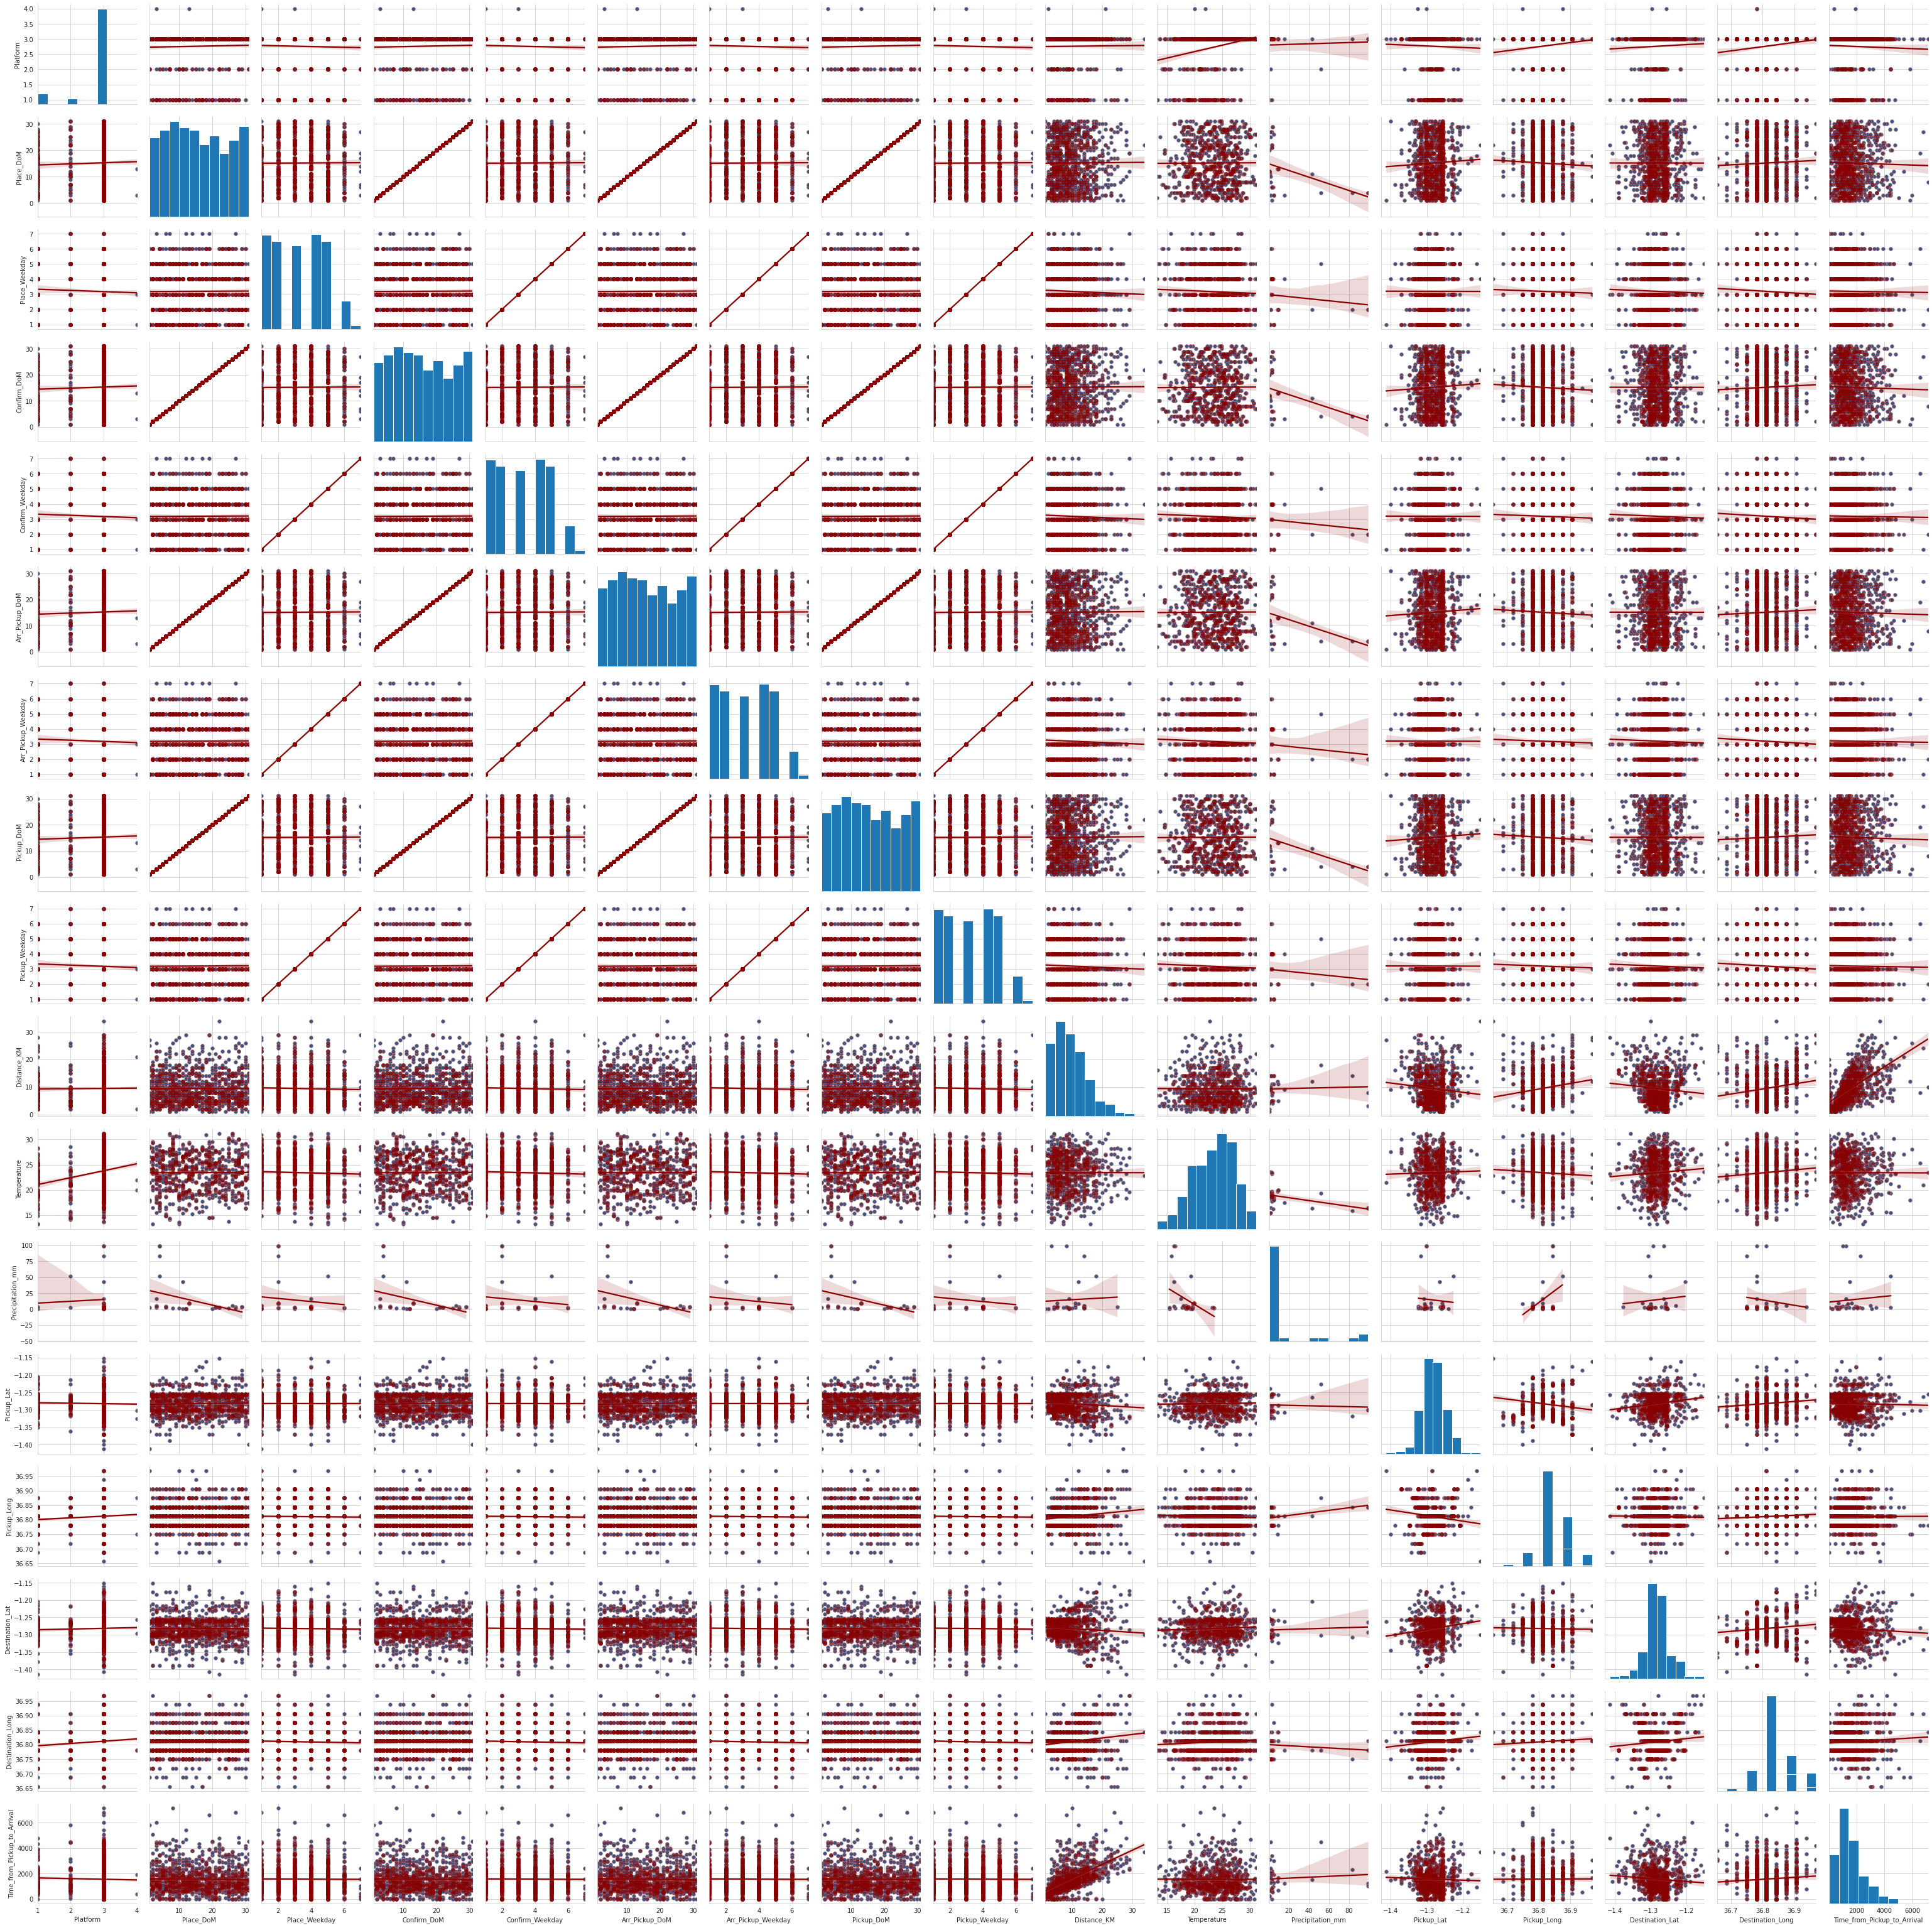

In [49]:
#split data into smaller subset for easier analysis on scatter plots without losing relatioships in the data
first_split = eda_df.sample(frac=0.05,random_state=200)
first_split
#Looking at the pairplot to compare variables
grid = sns.pairplot(data = first_split)

# Map a scatter plot to the bivariates, with alpha
grid = grid.map_upper(plt.scatter, color = 'darkred',alpha = 0.15)
grid = grid.map_lower(plt.scatter, color = 'darkred',alpha = 0.15)

#reg plot
grid = grid.map_upper(sns.regplot, color="darkred",scatter_kws={'alpha':0.15})
grid = grid.map_lower(sns.regplot, color="darkred", scatter_kws={'alpha':0.15})

# Map a histogram to the diagonal
#grid = grid.map_diag(plt.hist, bins = 10, color = 'darkred', 
                     #edgecolor = 'k')


**Analysis**

This plot gives the ability to see the relationship one variable has with another, the issue with plotting pairplots that has many datapoints is overplotting. Therefore added transparency to the dots to allow for overlaps to be visible, also reduced data size by taking a random sample without losing value to the data and decrease overlapping. Further analysis will be done using a heat map, where colour indicates the number of points in each bin. 

1. **Perfect positive linearity**

We can see that all four of the day of the month categories(Placement, Confirmation, Arrival at pickup, pickup) seem to have a very strong linear relationship, this could cause multicolinearity if the model trains all these day of the month categories. The same goes for the weekdays with a few having one or two outliers, it is safe to say all wekkday categories show strong linearity which should intuitively be dealt with before training the model.

2. **Positive linearity**

Distance has positve correlation with the the dependent variable y. This shows as a good indicator that there is a linear relationship.

3. **Categorical variables evident in dependent variables**

It is evident in the plot that some data shows a pattern of categorical data. The variables with this tendency is platform and weekday. The gps long coordinates show categorical patterns, but since the coordinates can take on any value with any level of specificity (or decimal places), it is confirmed to be continuous in this data form. 

4. **Futher Analysis** 

Some of the variables do not show correlation at all, the gps coordiantes lat shows a spread of data with a specific hot spot, this could be due to how close decimal degrees can be in one area but different location. The day of month and temperature seem to be quite spread out and shows no correlation. Precipitation shows no correlation but has a few deliveries with heavy rain that gives the correlation a slight positive (outliers).





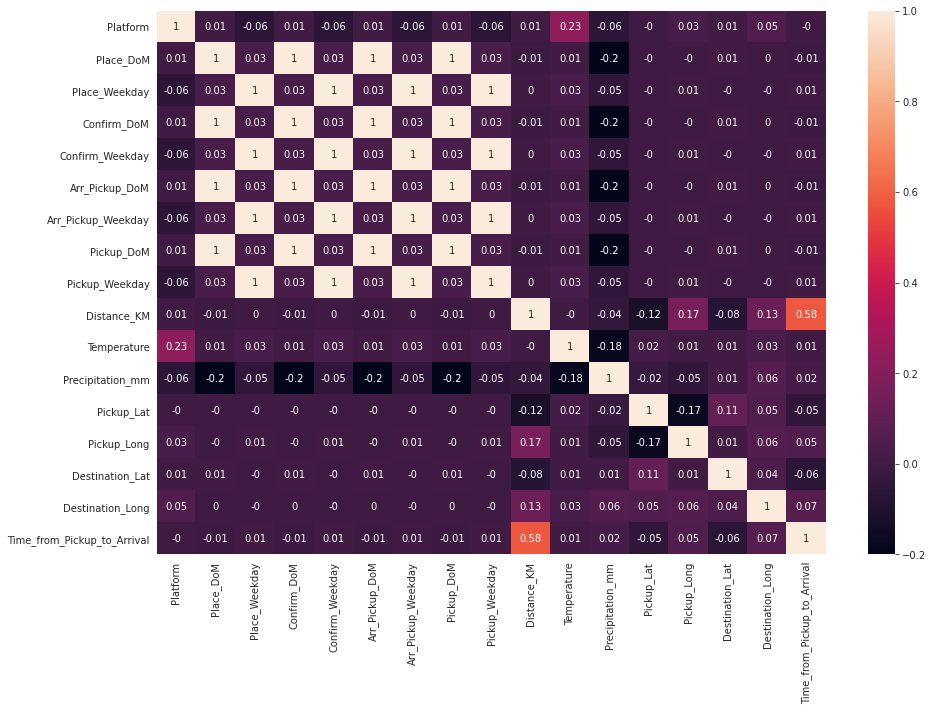

In [50]:
fig = plt.figure(figsize=(15,10))
sns.heatmap(eda_df.corr().round(2), annot=True)

From the above correlation matrix some features are strongly postively and negatively correlated, suggesting that these features may lead to an increased standard error as well as a difficulty to determine the effect of any one predictor variable on the response variable. This could lead to the removal of some if not all of these features.

#### 4. Remove Collinearity


In [0]:
def collinear(df):
  """Function that drops chosen columns
  Parameters
  ----------
  df: DataFrame
          DataFrame to drop columns from
  cols: list-like
          Names of columns to be dropped from
  Returns
  -------
  col_df: DataFrame
          Modified DataFrame
  """
  col_df = df.copy()
  droplist = ['Place_DoM', 'Place_Weekday',
              'Place_Time', 'Confirm_DoM', 
              'Confirm_Weekday', 'Confirm_Time',
              'Arr_Pickup_DoM', 'Arr_Pickup_Weekday',
              'Arr_Pickup_Time']
  if droplist[0] in col_df.columns:
    col_df = col_df.drop(columns=droplist)
  
  return col_df


In [0]:
btrain = collinear(eda_df)
btest = collinear(eda_test)
briders = collinear(eda_riders) 
btrain

,User_Id,Vehicle_Type,Platform,Pers_Business,Pickup_DoM,Pickup_Weekday,Pickup_Time,Distance_KM,Temperature,Precipitation_mm,Pickup_Lat,Pickup_Long,Destination_Lat,Destination_Long,Rider_Id,Time_from_Pickup_to_Arrival
Order No,,,,,,,,,,,,,,,,
Order_No_4211,User_Id_633,Bike,3,Business,9,5,10:27:30,4,20.406250,NaN,-1.317383,36.84375,-1.300781,36.84375,Rider_Id_432,745
Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:44:09,16,26.406250,NaN,-1.351562,36.90625,-1.294922,36.81250,Rider_Id_856,1993
Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:53:03,3,NaN,NaN,-1.308594,36.84375,-1.300781,36.84375,Rider_Id_155,455
Order_No_9336,User_Id_1402,Bike,3,Business,15,5,09:43:06,9,19.203125,NaN,-1.281250,36.84375,-1.256836,36.78125,Rider_Id_855,1341
Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,10:05:23,9,15.398438,NaN,-1.266602,36.78125,-1.294922,36.81250,Rider_Id_770,1214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Order_No_8834,User_Id_2001,Bike,3,Personal,20,3,16:20:08,3,28.593750,NaN,-1.258789,36.81250,-1.275391,36.81250,Rider_Id_953,9
Order_No_22892,User_Id_1796,Bike,3,Business,13,6,10:33:27,7,26.000000,NaN,-1.307617,36.81250,-1.332031,36.84375,Rider_Id_155,770
Order_No_2831,User_Id_2956,Bike,3,Business,7,4,17:50:52,20,29.203125,NaN,-1.286133,36.90625,-1.258789,36.81250,Rider_Id_697,2953


6. Missing values treatment (HELPER FUNCTIONS)

In [0]:
def null(df, na_thresh = 1.0 , strategy = "median"):
  """Function that drops columns with more than na_thresh null from
  
  """
  no_null=df.copy()
  # Dropping NaN's
  for col in no_null.columns:
    missing = no_null[col].isnull().sum()/len(no_null)
    if missing > na_thresh:
      no_null.drop(columns=col, inplace=True)
    
  # Filling NaN's
  for col in no_null.columns:
    if no_null[col].isnull().sum() > 0:
      if no_null[col].dtypes == 'object':
        no_null[col].fillna(no_null[col].mode(), inplace=True) 
      elif strategy == 'mean':
        no_null[col].fillna(round(no_null[col].mean()), inplace=True)
      elif strategy == 'median':
        no_null[col].fillna(round(no_null[col].median()), inplace=True)
      elif strategy == 'rolling':
        no_null[col].fillna(no_null[col].rolling(7).mean(), inplace=True)
      else:
        raise ValueError
  return no_null

In [0]:
ctrain = null(btrain)
ctest = null(btest)
criders = null(briders)

b. Feature engineering and selection (B)


1. Variable transformation

In [0]:
def variable_transformer(df):
  """Function to apply variable ALL transformations to dataset
  Parameters
  ----------
  df: DataFrame
          Input df to be transformed
  Returns
  -------
  trans_df: DataFrame
          Output df
  """
  trans_df = df.copy()
  return trans_df

In [0]:
pd.merge(ctrain, criders, how='left', on='Rider_Id')

,User_Id,Vehicle_Type,Platform,Pers_Business,Pickup_DoM,Pickup_Weekday,Pickup_Time,Distance_KM,Temperature,Precipitation_mm,Pickup_Lat,Pickup_Long,Destination_Lat,Destination_Long,Rider_Id,Time_from_Pickup_to_Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,User_Id_633,Bike,3,Business,9,5,10:27:30,4,20.406250,3.0,-1.317383,36.84375,-1.300781,36.84375,Rider_Id_432,745,1637,1309,13.796875,549
1,User_Id_2285,Bike,3,Personal,12,5,11:44:09,16,26.406250,3.0,-1.351562,36.90625,-1.294922,36.81250,Rider_Id_856,1993,396,339,13.601562,69
2,User_Id_265,Bike,3,Business,30,2,12:53:03,3,24.000000,3.0,-1.308594,36.84375,-1.300781,36.84375,Rider_Id_155,455,1023,242,12.500000,114
3,User_Id_1402,Bike,3,Business,15,5,09:43:06,9,19.203125,3.0,-1.281250,36.84375,-1.256836,36.78125,Rider_Id_855,1341,886,283,14.500000,113
4,User_Id_1737,Bike,1,Personal,13,1,10:05:23,9,15.398438,3.0,-1.266602,36.78125,-1.294922,36.81250,Rider_Id_770,1214,2311,872,14.101562,533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21196,User_Id_2001,Bike,3,Personal,20,3,16:20:08,3,28.593750,3.0,-1.258789,36.81250,-1.275391,36.81250,Rider_Id_953,9,1270,367,14.398438,131
21197,User_Id_1796,Bike,3,Business,13,6,10:33:27,7,26.000000,3.0,-1.307617,36.81250,-1.332031,36.84375,Rider_Id_155,770,1023,242,12.500000,114
21198,User_Id_2956,Bike,3,Business,7,4,17:50:52,20,29.203125,3.0,-1.286133,36.90625,-1.258789,36.81250,Rider_Id_697,2953,314,473,13.796875,29
21199,User_Id_2524,Bike,1,Personal,4,3,09:45:15,13,15.000000,3.0,-1.250000,36.87500,-1.279297,36.78125,Rider_Id_347,1380,2451,1821,14.000000,1101


2. Variable creation

### 6. Model building

## 6. Results interpretation

## 7. Conclusion